In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
import os
import sys
from os.path import join
from os.path import sep


In [3]:
BUZZ_path="./data"

In [4]:
train_filename_paths = glob.glob(join(BUZZ_path,"trainset") + sep + "*.png")
validation_filename_paths = glob.glob(join(BUZZ_path,"validationset") + sep + "*.png")
test_filename_paths = glob.glob(join(BUZZ_path,"testset") + sep + "*.png")

display(train_filename_paths[:10])
display(validation_filename_paths[:10])

['./data/trainset/cricket_03378.png',
 './data/trainset/noise_09049.png',
 './data/trainset/cricket_03568.png',
 './data/trainset/bee_00204.png',
 './data/trainset/bee_01582.png',
 './data/trainset/bee_00881.png',
 './data/trainset/bee_01173.png',
 './data/trainset/bee_00108.png',
 './data/trainset/bee_02226.png',
 './data/trainset/noise_08348.png']

['./data/validationset/cricket_09879.png',
 './data/validationset/cricket_09553.png',
 './data/validationset/bee_09121.png',
 './data/validationset/cricket_09810.png',
 './data/validationset/cricket_09656.png',
 './data/validationset/noise_09954.png',
 './data/validationset/cricket_09671.png',
 './data/validationset/bee_09354.png',
 './data/validationset/bee_09277.png',
 './data/validationset/cricket_09903.png']

In [5]:
print("Train: {}; Val: {}; Test: {}".format(len(train_filename_paths), len(validation_filename_paths), len(test_filename_paths)))

Train: 6684; Val: 1150; Test: 0


In [6]:
name_to_numeric = {"bee" : 0, "cricket" : 1, "noise" : 2}

def get_class_from_path(path):
    class_name = (os.path.split(path)[-1]).split('_')[0]
    numerical_class = name_to_numeric[class_name]
    return numerical_class

In [7]:
train_labels = list(map(get_class_from_path, train_filename_paths))
validation_labels = list(map(get_class_from_path, validation_filename_paths))

In [8]:

for pathname, classname in zip(train_filename_paths[:10], train_labels[:10]):
    print("{} {}".format(classname, pathname))
    

1 ./data/trainset/cricket_03378.png
2 ./data/trainset/noise_09049.png
1 ./data/trainset/cricket_03568.png
0 ./data/trainset/bee_00204.png
0 ./data/trainset/bee_01582.png
0 ./data/trainset/bee_00881.png
0 ./data/trainset/bee_01173.png
0 ./data/trainset/bee_00108.png
0 ./data/trainset/bee_02226.png
2 ./data/trainset/noise_08348.png


In [9]:

for pathname, classname in zip(validation_filename_paths[:10], validation_labels[:10]):
    print("{} {}".format(classname, pathname))
    

1 ./data/validationset/cricket_09879.png
1 ./data/validationset/cricket_09553.png
0 ./data/validationset/bee_09121.png
1 ./data/validationset/cricket_09810.png
1 ./data/validationset/cricket_09656.png
2 ./data/validationset/noise_09954.png
1 ./data/validationset/cricket_09671.png
0 ./data/validationset/bee_09354.png
0 ./data/validationset/bee_09277.png
1 ./data/validationset/cricket_09903.png


In [10]:
def parse_image_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=1)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize is not actually needed but it is good to have the image dimensions in the
    # Tensor shape
    image = tf.image.resize_images(image, [100, 100])
    return image, label

In [11]:
BATCH_SIZE=100

In [12]:
reset_graph()

The dataset is formed by tuples where the first element is the encoded image and the second is the class

In [13]:
def get_inputs(filenames, labels, batch_size, parallel_tasks=4):
    num_samples = len(filenames)
    assert len(filenames) == len(labels), "Filenames and labels should have same length"
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
    dataset = dataset.map(parse_image_function, num_parallel_calls=4)
#     dataset = dataset.shuffle(num_samples)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    
    iterator = dataset.make_initializable_iterator()
    images, labels = iterator.get_next()
    iterator_init_op = iterator.initializer
    
    inputs = {'images': images, 'labels': labels, 'iterator_init_op': iterator_init_op}
    return inputs
    
train_inputs = get_inputs(train_filename_paths, train_labels, BATCH_SIZE)
train_inputs

{'images': <tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>}

In [14]:
validation_inputs = get_inputs(validation_filename_paths, validation_labels, len(validation_filename_paths))
validation_inputs

{'images': <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 100, 100, 1) dtype=float32>,
 'iterator_init_op': <tf.Operation 'MakeIterator_1' type=MakeIterator>,
 'labels': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>}

Run a simple iteration to see if the labels are actually changing

In [15]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    sess.run(train_inputs['iterator_init_op'])
    print(sess.run(train_inputs['labels']))
    print(sess.run(train_inputs['labels']))
    print(sess.run(train_inputs['labels']))

[1 2 1 0 0 0 0 0 0 2 0 0 0 0 2 2 2 0 2 1 1 1 1 0 0 0 0 1 1 0 1 2 0 0 1 0 1
 2 0 0 2 1 0 2 2 2 2 2 0 2 0 0 0 0 1 2 2 0 0 0 2 1 0 2 0 0 0 0 1 0 1 2 0 1
 1 1 0 1 0 1 2 2 0 0 0 1 0 0 1 1 1 1 0 2 1 2 2 0 0 1]
[0 2 1 2 1 2 1 2 0 0 1 1 1 0 0 0 1 1 1 2 1 2 0 1 1 0 1 0 0 2 2 1 2 2 1 0 1
 0 1 0 0 2 2 2 1 2 0 0 0 0 1 0 0 0 2 1 1 1 1 0 0 1 2 2 1 0 2 1 0 1 1 2 0 1
 0 2 2 0 0 1 0 0 0 0 2 1 2 2 1 1 2 0 0 2 1 1 2 2 1 1]
[2 0 1 2 0 2 2 0 2 0 0 2 0 0 0 0 0 2 2 0 0 1 1 2 1 1 0 1 1 0 2 0 0 1 1 2 0
 0 2 0 1 0 0 2 2 0 0 1 2 2 0 0 2 1 2 2 2 1 2 0 2 0 2 2 1 2 0 0 1 2 2 0 1 0
 2 2 0 0 1 1 2 1 0 1 0 1 0 0 1 0 1 1 1 1 2 2 2 2 1 0]


In [16]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    sess.run(train_inputs['iterator_init_op'])
    total_images = 0
    for i in range(1000):
        print(i)
        total_images += len(sess.run(train_inputs['labels']))
        print(total_images)

0
100
1
200
2
300
3
400
4
500
5
600
6
700
7
800
8
900
9
1000
10
1100
11
1200
12
1300
13
1400
14
1500
15
1600
16
1700
17
1800
18
1900
19
2000
20
2100
21
2200
22
2300
23
2400
24
2500
25
2600
26
2700
27
2800
28
2900
29
3000
30
3100
31
3200
32
3300
33
3400
34
3500
35
3600
36
3700
37
3800
38
3900
39
4000
40
4100
41
4200
42
4300
43
4400
44
4500
45
4600
46
4700
47
4800
48
4900
49
5000
50
5100
51
5200
52
5300
53
5400
54
5500
55
5600
56
5700
57
5800
58
5900
59
6000
60
6100
61
6200
62
6300
63
6400
64
6500
65
6600
66
6684
67


OutOfRangeError: End of sequence
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,100,100,1], [?]], output_types=[DT_FLOAT, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Iterator)]]

Caused by op 'IteratorGetNext', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-aca3acc54fd1>", line 17, in <module>
    train_inputs = get_inputs(train_filename_paths, train_labels, BATCH_SIZE)
  File "<ipython-input-13-aca3acc54fd1>", line 11, in get_inputs
    images, labels = iterator.get_next()
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 366, in get_next
    name=name)), self._output_types,
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1455, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/giorgio/virtualenvs/shazura/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): End of sequence
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,100,100,1], [?]], output_types=[DT_FLOAT, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Iterator)]]


In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    sess.run(validation_inputs['iterator_init_op'])
    display(sess.run(validation_inputs['labels'])[:30])


In [17]:
train_inputs["images"]

<tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 1) dtype=float32>

In [18]:
# a simple model, just a perceptron
# images = train_inputs["images"]
images = tf.placeholder(tf.float32, [None,100,100,1])



flatten_images = tf.reshape(images, [-1, 100*100])

dense1 = tf.layers.dense(
    flatten_images,
    100,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)

dense2 = tf.layers.dense(
    dense1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)


logits=dense2
logits.shape




TensorShape([Dimension(None), Dimension(3)])

In [19]:
# labels = train_inputs['labels']
# print(labels.shape)
# raw_labels = tf.placeholder
# labels = tf.cast(labels, tf.int64)

raw_labels = tf.placeholder(tf.int32,[None, ])
labels = tf.cast(raw_labels, tf.int64)
predictions = tf.argmax(logits,1)

print(predictions.shape)  # should be (?, )

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(0.005)
train_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))
confusion_matrix = tf.confusion_matrix(labels, predictions)


(?,)


In [22]:
init = tf.global_variables_initializer()

metrics = {'accuracy_train' : [], 'accuracy_val' : [], 'loss_train' : [], 'loss_val': [], 'beat_train':[], 'beat_val':[]}

NUM_EPOCHS=10

EVAL_EVERY_N_BATCHES=5

with tf.Session() as sess:
    init.run()
    beat = 0
    # actual training
    for epoch in range(NUM_EPOCHS):
        print("Epoch {}".format(epoch))
        # restart from beginning of the dataset
        sess.run(train_inputs['iterator_init_op'])
        
        for batch_index in range(len(train_filename_paths)//BATCH_SIZE):
            train_images_data, train_labels_data = sess.run([train_inputs["images"], train_inputs["labels"]])
            print(train_images_data.shape)
            train_op_res, loss_train, accuracy_train = sess.run([train_op, loss, accuracy], feed_dict={images: train_images_data, raw_labels: train_labels_data  })
            metrics['accuracy_train'].append(accuracy_train)
            metrics['loss_train'].append(loss_train)
            
            print("{}:{} Train Loss: {}".format(epoch,batch_index,loss_train))
            print("{}:{} Train Acc: {}".format(epoch,batch_index,accuracy_train))
            
            metrics['beat_train'].append(beat)
            
            # do the evaluation only some times
            if beat % EVAL_EVERY_N_BATCHES == 0:
                sess.run(validation_inputs['iterator_init_op'])
                validation_images_data, validation_labels_data = sess.run([validation_inputs["images"], validation_inputs["labels"]])
                loss_val, accuracy_val = sess.run([loss, accuracy], feed_dict={images: validation_images_data, raw_labels: validation_labels_data  })
                print("{}:{} Val Loss: {}".format(epoch,batch_index,loss_val))
                print("{}:{} Val Acc: {}".format(epoch,batch_index,accuracy_val))
                metrics['accuracy_val'].append(accuracy_val)
                metrics['loss_val'].append(loss_val)
                metrics['beat_val'].append(beat)
                confusion_matrix_res = sess.run([confusion_matrix], feed_dict={images: validation_images_data, raw_labels: validation_labels_data  })
                print(confusion_matrix_res)
                
            beat = beat + 1 #  not very pythonic I know,
#             print(beat)
            
            print()
        
        
            

Epoch 0
(100, 100, 100, 1)
0:0 Train Loss: 8.523287773132324
0:0 Train Acc: 0.25
0:0 Val Loss: 10.195075035095215
0:0 Val Acc: 0.260869562625885
[array([[300,   0,   0],
       [500,   0,   0],
       [350,   0,   0]], dtype=int32)]

(100, 100, 100, 1)
0:1 Train Loss: 8.508308410644531
0:1 Train Acc: 0.3499999940395355

(100, 100, 100, 1)
0:2 Train Loss: 5.217715263366699
0:2 Train Acc: 0.27000001072883606

(100, 100, 100, 1)
0:3 Train Loss: 5.972506523132324
0:3 Train Acc: 0.25999999046325684

(100, 100, 100, 1)
0:4 Train Loss: 4.776127815246582
0:4 Train Acc: 0.36000001430511475

(100, 100, 100, 1)
0:5 Train Loss: 4.891873359680176
0:5 Train Acc: 0.25
0:5 Val Loss: 4.600724697113037
0:5 Val Acc: 0.30434781312942505
[array([[  0,   0, 300],
       [  0,   0, 500],
       [  0,   0, 350]], dtype=int32)]

(100, 100, 100, 1)
0:6 Train Loss: 3.4656271934509277
0:6 Train Acc: 0.3700000047683716

(100, 100, 100, 1)
0:7 Train Loss: 4.626197338104248
0:7 Train Acc: 0.3499999940395355

(100, 1

In [80]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

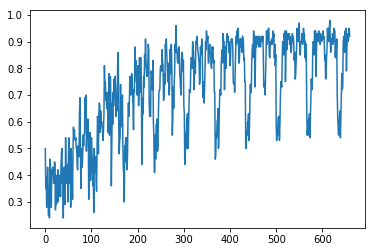

In [81]:
values = metrics['accuracy_train']
plt.plot(range(len(values)), values)

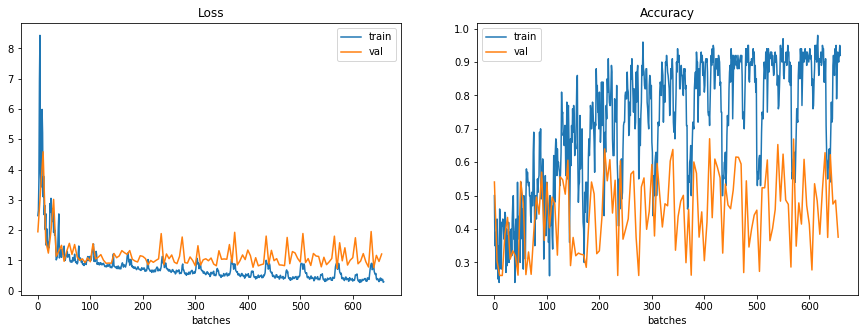

In [82]:
def plot_metrics(metrics, figsize=(15,5)):
    _x_train = metrics['beat_train']
    _x_val = metrics['beat_val']
    fig, axes = plt.subplots(1,2, figsize=figsize)
    # loss ax
    axes[0].plot(_x_train, metrics['loss_train'], label="train")
    axes[0].plot(_x_val, metrics['loss_val'], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("batches")
    axes[0].legend()
    
    # accuracy ax
    axes[1].plot(_x_train, metrics['accuracy_train'], label="train")
    axes[1].plot(_x_val, metrics['accuracy_val'], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("batches")
    axes[1].legend()

plot_metrics(metrics)


So, the first results of the simple MLP with 100 hidden units gives a very instable accuracy, but almost always better than a fair coin toss (33%, since we are classifiyng 3 labels.

## Conv

In [83]:
reset_graph()

In [ ]:
images = tf.placeholder(tf.float32, [None,100,100,1])

conv1 = tf.layers.conv2d(
    images, 
    filters=100, 
    kernel_size=3, 
    strides=1, 
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11),
)

max_pool1 = tf.layers.max_pooling2d(conv1, [])


flatten_images = tf.reshape(images, [-1, 100*100])

dense1 = tf.layers.dense(
    flatten_images,
    100,
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)

dense2 = tf.layers.dense(
    dense1,
    3,
    kernel_initializer=tf.initializers.random_uniform(-0.2, 0.2),
    bias_initializer=tf.initializers.random_uniform(0.09, 0.11)
)


logits=dense2
logits.shape